In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [134]:
from scipy import stats
import matplotlib.pyplot as plt

'''
Function that takes in two dataframe columns and plots a log-log graph
Follows standardised formatting
@input recorded: dataframe column of recorded data
@input predicted: dataframe column of the predicted value
@input xmin: lower bound of graph's x axis
@input xmax: upper bound of graph's x axis
@input ymin: lower bound of graph's y axis
@input ymax: upper bound of graph's y axis
@input xTitle: title for x axis
@input yTitle: title for y axis
@output log log graph of the preducted values against recorded values
'''

def logLogPlotter(recorded, predicted, xmin, xmax, ymin, ymax, xTitle, yTitle, units):
    x = recorded
    y = predicted

    coefficients = np.polyfit(np.log(x), np.log(y), 1)
    line_function = np.poly1d(coefficients)

    # Create a range for predicted values for the fit line
    x_vals = np.linspace(min(x), max(y), 400)
    y_vals = np.exp(line_function(np.log(x_vals)))

    #calculate similarity measures
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    #best fit line and y = x line
    plt.scatter(x, y, c='red', marker='x')
    plt.plot(x_vals, y_vals, color='red', label=f'Fit: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')
    plt.axline((0, 0), (1,1),color='black',linestyle='--', label=f'y=x, R^2 = {r_value ** 2}',)

    #visuals
    font_family = 'Times New Roman'
    title_font_size=17
    label_font_size=15
    legend_tick_font_size=12

    plt.title(f'Predicted {yTitle} against Recorded {xTitle}', fontsize=title_font_size, fontfamily=font_family)
    plt.xlabel(f'Recorded {xTitle} ({units})', fontsize=label_font_size, fontfamily=font_family)
    plt.ylabel(f'Predicted {yTitle} ({units})', fontsize=label_font_size, fontfamily=font_family)

    plt.legend(fontsize = legend_tick_font_size)
    plt.loglog()
    plt.xlim(xmax=xmax, xmin=xmin)
    plt.ylim(ymax=ymax, ymin=ymin)

    plt.show()

In [135]:
data = pd.read_csv('../data/task2.1data.csv')
data[:5]

,M,air_temp,load_resistance,i_d,output_voltage,power_output
0,0.0,10.0,200.0,24.3,46.0,87.3
1,1.0,10.0,200.0,24.3,27.9,64.2
2,2.0,10.0,200.0,24.3,27.9,32.1
3,0.0,10.0,200.0,51.8,46.0,40.9
4,1.0,10.0,200.0,51.8,92.1,163.9


## Median values

In [136]:
data.median()

M                    1.00
air_temp            10.00
load_resistance    600.00
i_d                 27.45
output_voltage      55.15
power_output       170.55
dtype: float64

In [137]:
median_values = data.median()

In [138]:
air_temp_med = median_values[1]
load_resistance_med = median_values[2]
i_d_med = median_values[3]
output_voltage_med = median_values[4]
power_output_med = median_values[5]

## Normalization

In [139]:
#we can just call this and not worry about M since the median for M is 1.
data = data.divide(data.median())
data

,M,air_temp,load_resistance,i_d,output_voltage,power_output
0,0.0,1.0,0.333333,0.885246,0.834089,0.511873
1,1.0,1.0,0.333333,0.885246,0.505893,0.376429
2,2.0,1.0,0.333333,0.885246,0.505893,0.188215
3,0.0,1.0,0.333333,1.887067,0.834089,0.239812
4,1.0,1.0,0.333333,1.887067,1.669991,0.961009
5,2.0,1.0,0.333333,1.887067,1.078876,0.401642
6,0.0,1.0,0.333333,3.504554,0.834089,0.128994
7,1.0,1.0,0.333333,3.504554,1.669991,0.517150
8,2.0,1.0,0.333333,3.504554,2.005440,0.745822
9,0.0,1.0,0.333333,6.196721,0.834089,0.072706


## Training and Validation set split

In [140]:
from sklearn.model_selection import train_test_split

In [141]:
X = data[['M', 'air_temp', 'load_resistance', 'i_d']]
y = data[['output_voltage', 'power_output']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=42)



In [142]:
X_test

,M,air_temp,load_resistance,i_d
27,1.0,1.0,0.833333,2.881603
40,1.0,1.0,1.666667,0.426230
26,0.0,1.0,0.833333,2.881603
43,1.0,1.0,1.666667,0.918033
24,2.0,1.0,1.166667,0.520947
37,1.0,1.0,1.666667,0.142805
12,0.0,1.0,0.833333,0.255009
19,1.0,1.0,0.833333,1.573770
4,1.0,1.0,0.333333,1.887067
25,2.0,1.0,0.833333,1.573770


In [143]:
'''>>>>> start CodeP3.1.2F23
    V.P. Carey ME249, Fall 2023

Intro to Neural Network Modeling 
Keras model for PV power system'''

#import useful packages
import keras
import pandas as pd
from keras.models import Sequential
import numpy as np
import keras.backend as kb
import tensorflow as tf
#the follwoing 2 lines are only needed for Mac OS machines
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# define meadian values of input variables - add your values here
Tamed = air_temp_med  #make sure Tamed does not = 0
IDmed = i_d_med
RLmed = load_resistance_med

#Part 1 input data: Air temp (degC), ID (W/sqm), load resistance (ohms)
xdata = X_train
xarray= np.array(xdata)
# print (xdata)
# print (xarray)

# define meadian values of output variables - add your values here
VLmed = output_voltage_med
Wdmed = power_output_med

#create output data array
ydata = y_train
yarray= np.array(ydata)
# print (ydata)
# print (yarray)

In [144]:
# define neural network model

#As seen below, we have created four dense layers. 
#A dense layer is a layer in neural network that’s fully connected. 
#In other words, all the neurons in one layer are connected to all other neurons in the next layer.
#In the first layer, we need to provide the input shape, which is 1 in our case. 
#The activation function we have chosen is elu, which stands for exponential linear unit. .

from keras import backend as K
#initialize weights with values between -0.2 and 0.5
initializer = keras.initializers.RandomUniform(minval= -0.5, maxval=0.5)

model = keras.Sequential([
keras.layers.Dense(10, activation=K.elu, input_shape=[4], kernel_initializer=initializer),
keras.layers.Dense(22, activation=K.elu, kernel_initializer=initializer),
keras.layers.Dense(10, activation=K.elu, kernel_initializer=initializer),
keras.layers.Dense(2, kernel_initializer=initializer)
])


In [145]:
#We’re using RMSprop as our optimizer here. RMSprop stands for Root Mean Square Propagation. 
#It’s one of the most popular gradient descent optimization algorithms for deep learning networks. 
#RMSprop is an optimizer that’s reliable and fast.
#We’re compiling the mode using the model.compile function. The loss function used here 
#is mean squared error. After the compilation of the model, we’ll use the fit method with ~500 epochs.
#Number of epochs can be varied.

#from tf.keras import optimizers
rms = keras.optimizers.RMSprop(0.020)
model.compile(loss='mean_absolute_error',optimizer=rms)


In [146]:
#After the compilation of the model, we’ll use the fit method with 500 epochs.
#I started with epochs value of 100 and then tested the model after training. 
#The prediction was not that good. Then I modified the number of epochs to 200 and tested the model again. 
#Accuracy had improved slightly, but figured I’d give it one more try. Finally, at 500 epochs 
#I found acceptable prediction accuracy.

#The fit method takes three parameters; namely, x, y, and number of epochs. 
#During model training, if all the batches of data are seen by the model once, 
#we say that one epoch has been completed.

# Add an early stopping callback
es = keras.callbacks.EarlyStopping(
    monitor='loss', 
    mode='min', 
    patience = 200, 
    restore_best_weights = True, 
    verbose=1)
# Add a checkpoint where loss is minimum, and save that model
mc = keras.callbacks.ModelCheckpoint('best_model.SB', monitor='loss', 
                     mode='min',  verbose=1, save_best_only=True)

historyData = model.fit(xarray,yarray,epochs=1200,callbacks=[es])

loss_hist = historyData.history['loss']
#The above line will return a dictionary, access it's info like this:
best_epoch = np.argmin(historyData.history['loss']) + 1
print ('best epoch = ', best_epoch)

print('smallest loss =', np.min(loss_hist))

# model.save('best_model.h5')

Epoch 1/1200
36/36 [==============================] - 0s 9ms/step - loss: 1.9882
Epoch 2/1200
36/36 [==============================] - 0s 95us/step - loss: 1.0288
Epoch 3/1200
36/36 [==============================] - 0s 83us/step - loss: 1.1365
Epoch 4/1200
36/36 [==============================] - 0s 123us/step - loss: 0.8907
Epoch 5/1200
36/36 [==============================] - 0s 85us/step - loss: 0.8861
Epoch 6/1200
36/36 [==============================] - 0s 105us/step - loss: 1.0129
Epoch 7/1200
36/36 [==============================] - 0s 135us/step - loss: 0.8675
Epoch 8/1200
36/36 [==============================] - 0s 85us/step - loss: 0.9161
Epoch 9/1200
36/36 [==============================] - 0s 96us/step - loss: 0.8379
Epoch 10/1200
36/36 [==============================] - 0s 95us/step - loss: 0.8753
Epoch 11/1200
36/36 [==============================] - 0s 105us/step - loss: 0.7898
Epoch 12/1200
36/36 [==============================] - 0s 95us/step - loss: 0.9461
Epoch 13/1

# (e)

## Training Set

In [147]:
y_predictions = model.predict(X_train[['M', 'air_temp', 'load_resistance', 'i_d']])
y_predictions_df = pd.DataFrame(y_predictions, columns=['output_voltage', 'power_output'])
y_predictions_df


,output_voltage,power_output
0,0.846933,0.189371
1,0.861431,0.594555
2,0.837157,0.218775
3,0.512248,0.557903
4,0.917773,1.551291
5,0.843162,0.278325
6,0.883055,0.445295
7,0.828573,0.057593
8,1.634988,2.543563
9,0.880670,0.614634


In [148]:
y_recorded_df = y_train[['output_voltage', 'power_output']]
y_recorded_df


,output_voltage,power_output
6,0.834089,0.128994
39,0.921124,1.294049
33,0.894016,0.257403
13,0.377153,0.728819
17,1.144152,1.103489
45,0.921124,0.363530
15,0.877607,0.649077
9,0.834089,0.072706
16,1.755213,2.596892
29,1.082502,1.464673


In [149]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_recorded_df['power_output'], y_predictions_df['power_output'])
print(f'MAE: {mae}')

MAE: 0.3124315907651487


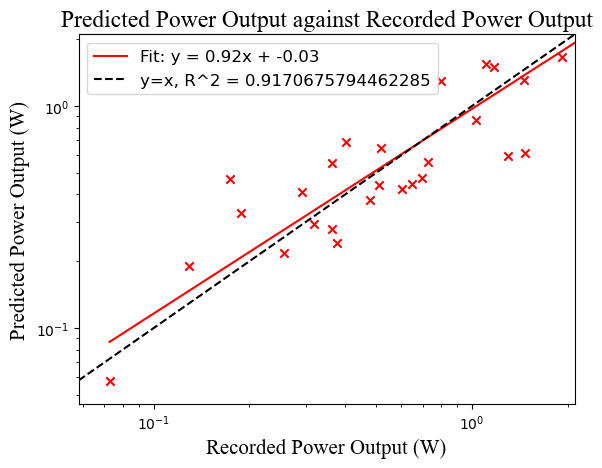

In [150]:
logLogPlotter(y_recorded_df['power_output'], y_predictions_df['power_output'], -0.5, 2.1, -0.5, 2.1, 'Power Output', 'Power Output', 'W')

# (f)

## Validation Set

In [151]:
y_predictions = model.predict(X_test[['M', 'air_temp', 'load_resistance', 'i_d']])
y_predictions_df = pd.DataFrame(y_predictions, columns=['output_voltage', 'power_output'])
y_predictions_df

,output_voltage,power_output
0,1.600875,0.619007
1,3.073368,3.732291
2,0.832981,0.165115
3,2.403799,2.406322
4,0.798968,1.676197
5,3.057948,4.010804
6,0.883245,0.484653
7,1.599079,1.199776
8,1.600985,1.145693
9,1.771019,1.938564


In [152]:
y_recorded_df = y_test[['output_voltage', 'power_output']]
y_recorded_df

,output_voltage,power_output
27,0.893926,0.996189
40,1.842248,5.177954
26,0.369900,0.501906
43,1.842248,2.403987
24,0.893926,2.908824
37,0.418858,1.600117
12,0.877607,1.965992
19,1.757026,1.274113
4,1.669991,0.961009
25,0.369900,1.003811


In [153]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_recorded_df['power_output'], y_predictions_df['power_output'])
print(f'MAE: {mae}')

MAE: 0.8901299037738979


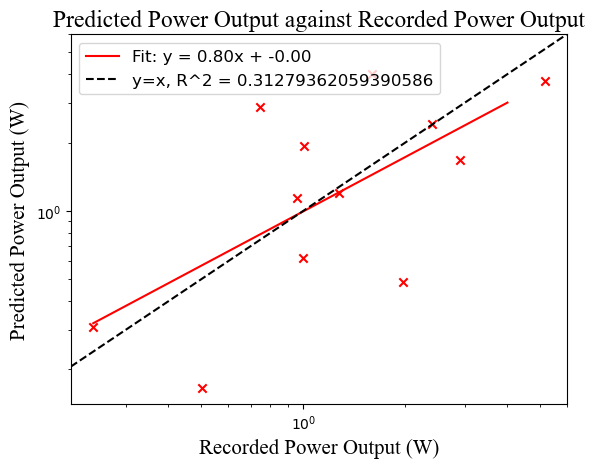

In [154]:
logLogPlotter(y_recorded_df['power_output'], y_predictions_df['power_output'], -0.5, 6, -0.5, 6, 'Power Output', 'Power Output', 'W')

## M0

In [155]:
m0_data = data[data['M'] == 0]
m0_data

,M,air_temp,load_resistance,i_d,output_voltage,power_output
0,0.0,1.0,0.333333,0.885246,0.834089,0.511873
3,0.0,1.0,0.333333,1.887067,0.834089,0.239812
6,0.0,1.0,0.333333,3.504554,0.834089,0.128994
9,0.0,1.0,0.333333,6.196721,0.834089,0.072706
12,0.0,1.0,0.833333,0.255009,0.877607,1.965992
15,0.0,1.0,0.833333,0.772313,0.877607,0.649077
18,0.0,1.0,0.833333,1.573770,0.877607,0.318382
22,0.0,1.0,1.166667,0.520947,1.755213,0.695984
26,0.0,1.0,0.833333,2.881603,0.369900,0.501906
29,0.0,1.0,1.166667,0.174863,1.082502,1.464673


In [156]:
y_recorded_df = m0_data[['output_voltage', 'power_output']]
y_recorded_df

,output_voltage,power_output
0,0.834089,0.511873
3,0.834089,0.239812
6,0.834089,0.128994
9,0.834089,0.072706
12,0.877607,1.965992
15,0.877607,0.649077
18,0.877607,0.318382
22,1.755213,0.695984
26,0.369900,0.501906
29,1.082502,1.464673


In [157]:
y_predictions = model.predict(m0_data[['M', 'air_temp', 'load_resistance', 'i_d']])
y_predictions_df = pd.DataFrame(y_predictions, columns=['output_voltage', 'power_output'])
y_predictions_df


,output_voltage,power_output
0,0.888663,0.441321
1,0.865517,0.307133
2,0.846933,0.189371
3,0.828573,0.057593
4,0.883245,0.484653
5,0.883055,0.445295
6,0.855527,0.294137
7,0.877819,0.472875
8,0.832981,0.165115
9,0.880670,0.614634


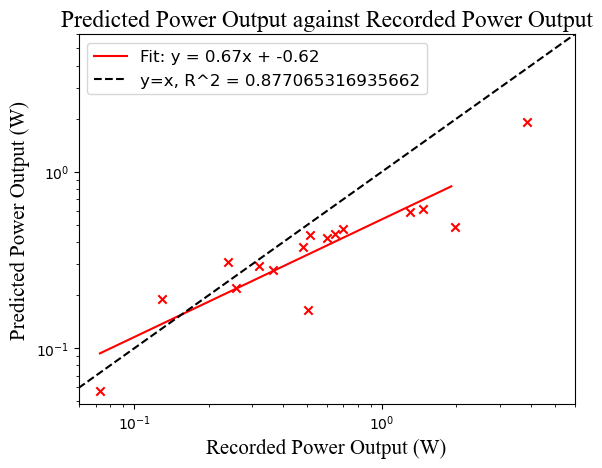

In [158]:
logLogPlotter(y_recorded_df['power_output'], y_predictions_df['power_output'], -0.5, 6, -0.5, 6, 'Power Output', 'Power Output', 'W')

# M1


In [159]:
m1_data = data[data['M'] == 1]
m1_data

,M,air_temp,load_resistance,i_d,output_voltage,power_output
1,1.0,1.0,0.333333,0.885246,0.505893,0.376429
4,1.0,1.0,0.333333,1.887067,1.669991,0.961009
7,1.0,1.0,0.333333,3.504554,1.669991,0.517150
10,1.0,1.0,0.333333,6.196721,1.669991,0.292583
13,1.0,1.0,0.833333,0.255009,0.377153,0.728819
16,1.0,1.0,0.833333,0.772313,1.755213,2.596892
19,1.0,1.0,0.833333,1.573770,1.757026,1.274113
20,1.0,1.0,1.166667,0.178506,2.333636,2.249194
23,1.0,1.0,1.166667,0.520947,3.512239,2.783934
27,1.0,1.0,0.833333,2.881603,0.893926,0.996189


In [160]:
y_recorded_df = m1_data[['output_voltage', 'power_output']]
y_recorded_df

,output_voltage,power_output
1,0.505893,0.376429
4,1.669991,0.961009
7,1.669991,0.517150
10,1.669991,0.292583
13,0.377153,0.728819
16,1.755213,2.596892
19,1.757026,1.274113
20,2.333636,2.249194
23,3.512239,2.783934
27,0.893926,0.996189


In [161]:
y_predictions = model.predict(m1_data[['M', 'air_temp', 'load_resistance', 'i_d']])
y_predictions_df = pd.DataFrame(y_predictions, columns=['output_voltage', 'power_output'])
y_predictions_df


,output_voltage,power_output
0,0.440851,0.241434
1,1.600985,1.145693
2,1.566830,0.645285
3,1.288710,0.409800
4,0.512248,0.557903
5,1.634988,2.543563
6,1.599079,1.199776
7,2.235581,2.003659
8,3.332724,2.709726
9,1.600875,0.619007


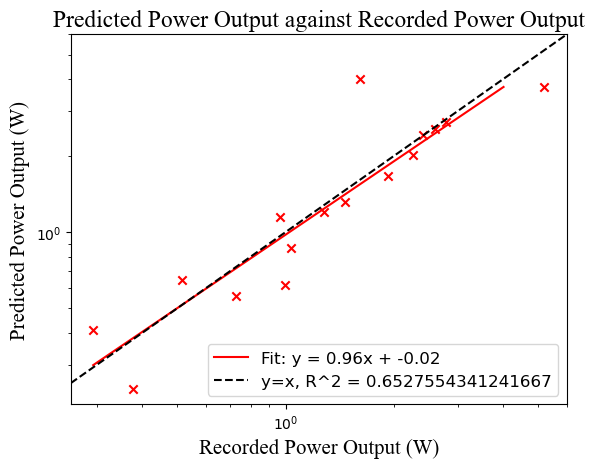

In [162]:
logLogPlotter(y_recorded_df['power_output'], y_predictions_df['power_output'], -0.5, 6, -0.5, 6, 'Power Output', 'Power Output', 'W')

# M2

In [163]:
m2_data = data[data['M'] == 2]
m2_data

,M,air_temp,load_resistance,i_d,output_voltage,power_output
2,2.0,1.0,0.333333,0.885246,0.505893,0.188215
5,2.0,1.0,0.333333,1.887067,1.078876,0.401642
8,2.0,1.0,0.333333,3.504554,2.005440,0.745822
11,2.0,1.0,0.333333,6.196721,3.339982,1.170331
14,2.0,1.0,0.833333,0.255009,0.377153,0.364116
17,2.0,1.0,0.833333,0.772313,1.144152,1.103489
21,2.0,1.0,1.166667,0.178506,0.877607,0.173556
24,2.0,1.0,1.166667,0.520947,0.893926,2.908824
25,2.0,1.0,0.833333,1.573770,0.369900,1.003811
28,2.0,1.0,0.833333,2.881603,1.787851,3.986514


In [164]:
y_predictions = model.predict(m2_data[['M', 'air_temp', 'load_resistance', 'i_d']])
y_predictions_df = pd.DataFrame(y_predictions, columns=['output_voltage', 'power_output'])
y_predictions_df


,output_voltage,power_output
0,0.430416,0.329585
1,0.958451,0.690081
2,2.168531,2.879664
3,3.596103,1.493958
4,0.417382,0.555299
5,0.917773,1.551291
6,0.598452,0.470400
7,0.798968,1.676197
8,1.771019,1.938564
9,1.890885,4.262207


In [165]:
y_recorded_df = m2_data[['output_voltage', 'power_output']]
y_recorded_df

,output_voltage,power_output
2,0.505893,0.188215
5,1.078876,0.401642
8,2.005440,0.745822
11,3.339982,1.170331
14,0.377153,0.364116
17,1.144152,1.103489
21,0.877607,0.173556
24,0.893926,2.908824
25,0.369900,1.003811
28,1.787851,3.986514


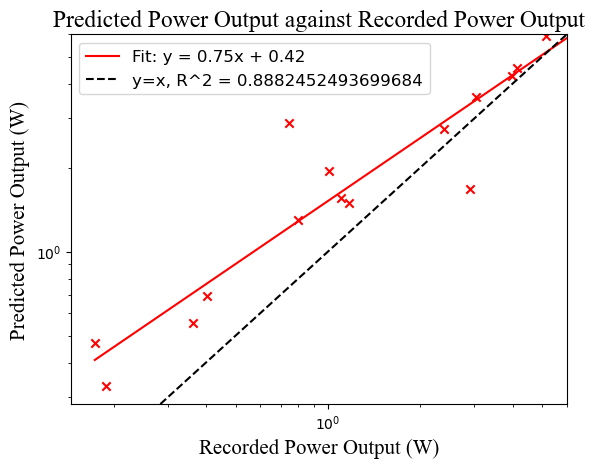

In [166]:
logLogPlotter(y_recorded_df['power_output'], y_predictions_df['power_output'], -0.5, 6, -0.5, 6, 'Power Output', 'Power Output', 'W')